   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.9/640.9 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.


Step 5: Generating summary report...

FOREST STRUCTURE ANALYSIS REPORT

Total Trees Detected: 5
Average Tree Height: 26.56 ± 2.69 m
Average Crown Diameter: 15.31 ± 4.64 m
Average DBH: 15.33 ± 1.37 m
Total Estimated Volume: 19471.48 m³


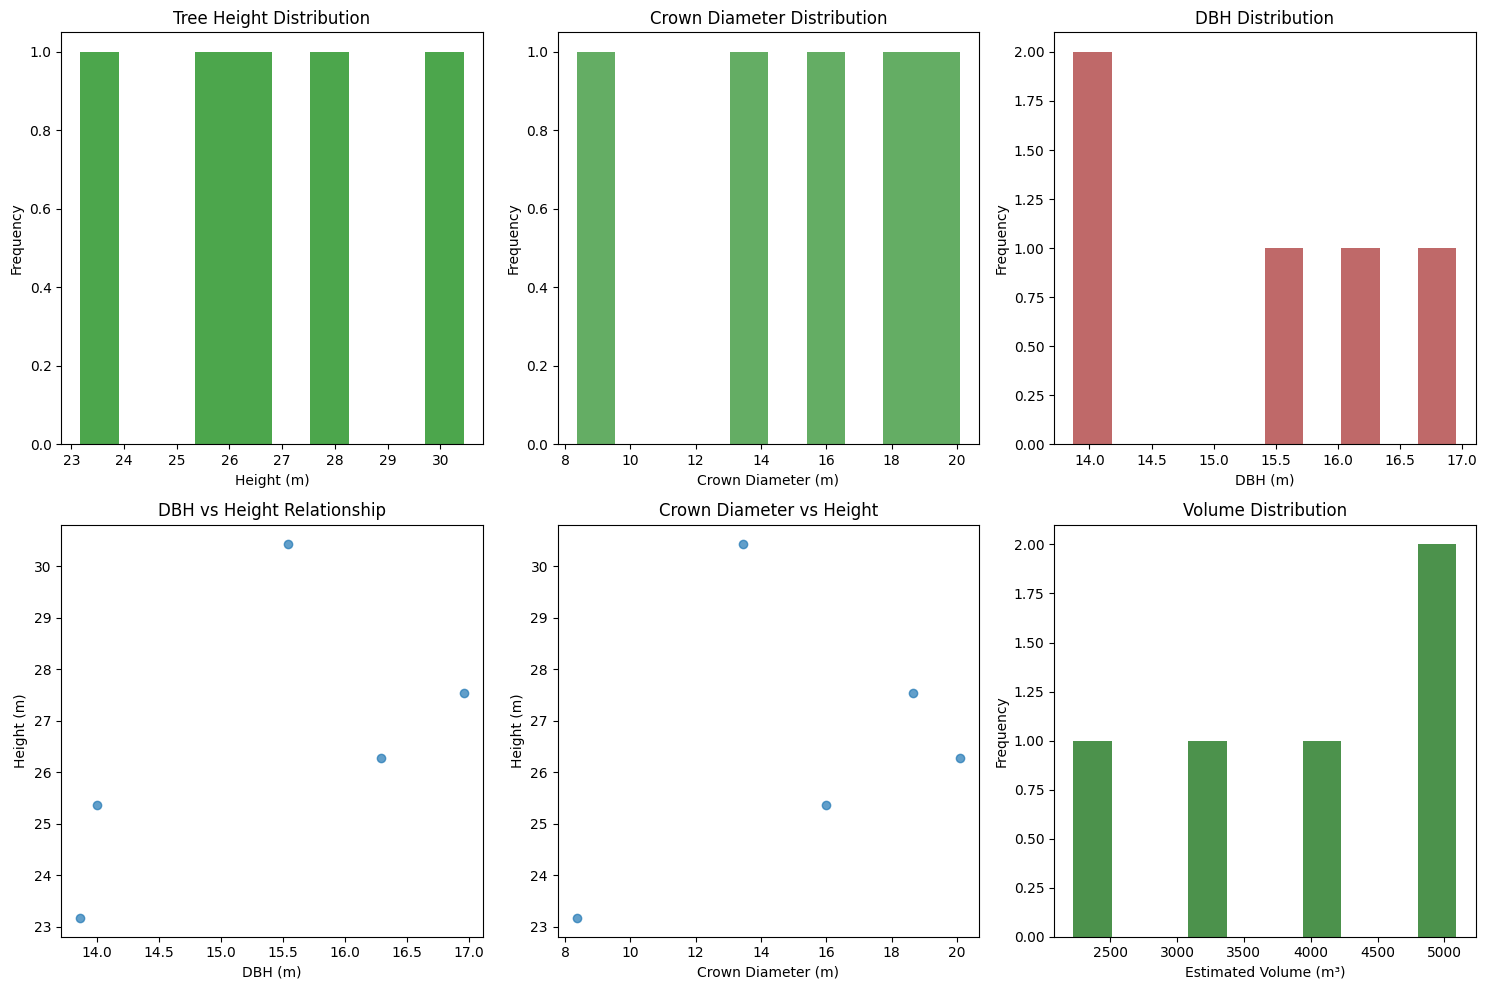

Exported forest data to forest_data.ply for Blender import
Simulating temporal forest changes...


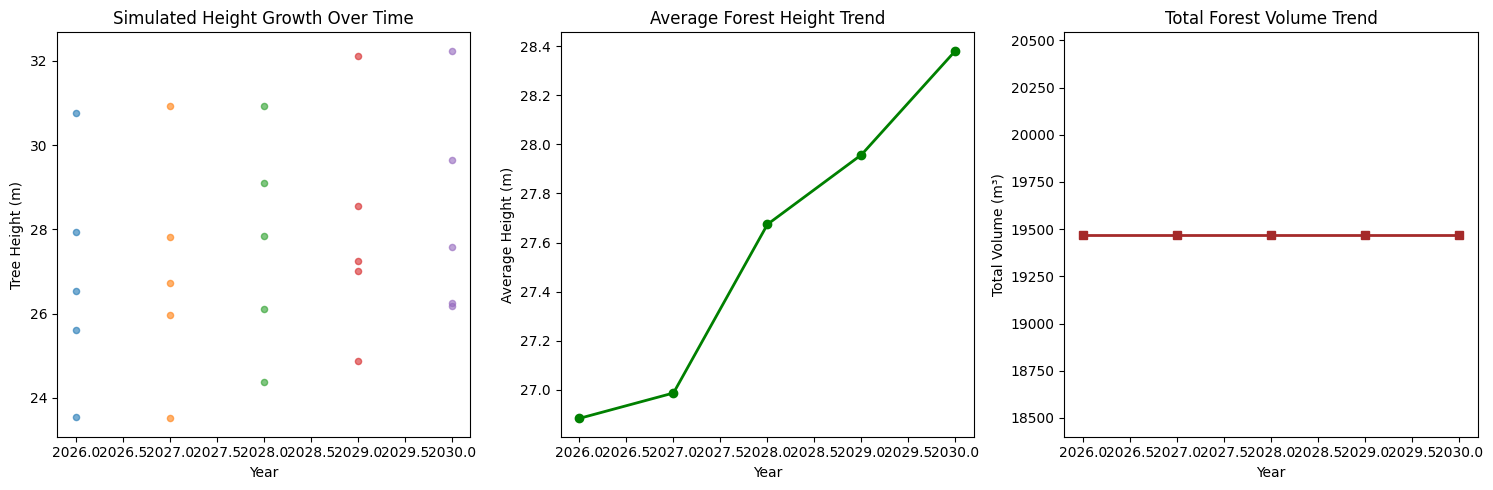


Analysis complete! Check the generated visualizations and exported data.
For Blender import: Use the generated 'forest_data.ply' file


In [ ]:
# 3D Forest Structure Analysis using LiDAR Data
# Complete implementation for Google Colab

# ===============================
# 1. SETUP AND INSTALLATIONS
# ===============================

# Install required packages
!pip install open3d laspy[lazrs] rasterio geopandas matplotlib seaborn plotly
!pip install scikit-learn numpy pandas scipy

# Import libraries
import numpy as np
import pandas as pd
import open3d as o3d
import laspy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import os
import zipfile
import requests
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 2. DATA LOADING AND PREPROCESSING
# ===============================

class LiDARForestAnalyzer:
    def __init__(self):
        self.point_cloud = None
        self.ground_points = None
        self.vegetation_points = None
        self.tree_segments = []

    def load_las_file(self, file_path):
        """Load LAS/LAZ file and convert to Open3D point cloud"""
        print("Loading LiDAR data...")

        # Read LAS file
        las_file = laspy.read(file_path)

        # Extract coordinates
        points = np.vstack((las_file.x, las_file.y, las_file.z)).transpose()

        # Extract colors if available
        colors = None
        if hasattr(las_file, 'red') and hasattr(las_file, 'green') and hasattr(las_file, 'blue'):
            colors = np.vstack((las_file.red, las_file.green, las_file.blue)).transpose()
            colors = colors / 65535.0  # Normalize to [0,1]

        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)

        if colors is not None:
            pcd.colors = o3d.utility.Vector3dVector(colors)

        # Store classification if available
        self.classification = las_file.classification if hasattr(las_file, 'classification') else None
        self.intensity = las_file.intensity if hasattr(las_file, 'intensity') else None

        self.point_cloud = pcd
        print(f"Loaded {len(pcd.points)} points")
        return pcd

    def download_sample_data(self):
        """Download sample LiDAR data for demonstration"""
        print("Downloading sample LiDAR data...")

        # Create sample data if no real data available
        # This creates a synthetic forest scene
        np.random.seed(42)

        # Generate ground points (flat with some noise)
        ground_x = np.random.uniform(-50, 50, 10000)
        ground_y = np.random.uniform(-50, 50, 10000)
        ground_z = np.random.normal(0, 0.5, 10000)
        ground_points = np.column_stack([ground_x, ground_y, ground_z])

        # Generate tree points (cylindrical structures)
        tree_points = []
        tree_centers = [(10, 10), (-10, 15), (20, -5), (-15, -20), (0, 30)]

        for center_x, center_y in tree_centers:
            # Tree trunk
            trunk_height = np.random.uniform(15, 25)
            trunk_radius = np.random.uniform(0.3, 0.8)

            for h in np.linspace(0.5, trunk_height, 200):
                angle = np.random.uniform(0, 2*np.pi, 5)
                radius = np.random.uniform(0, trunk_radius, 5)
                x = center_x + radius * np.cos(angle)
                y = center_y + radius * np.sin(angle)
                z = np.full_like(x, h)
                tree_points.extend(np.column_stack([x, y, z]))

            # Tree crown (spherical/elliptical)
            crown_points = 1000
            crown_center_z = trunk_height + 5
            crown_radius = np.random.uniform(3, 8)

            for _ in range(crown_points):
                # Generate points in ellipsoid
                u = np.random.uniform(0, 2*np.pi)
                v = np.random.uniform(0, np.pi)
                r = np.random.uniform(0, crown_radius)

                x = center_x + r * np.sin(v) * np.cos(u)
                y = center_y + r * np.sin(v) * np.sin(u)
                z = crown_center_z + r * np.cos(v) * 0.6  # Flatten vertically

                tree_points.append([x, y, z])

        # Combine all points
        all_points = np.vstack([ground_points, np.array(tree_points)])

        # Create point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(all_points)

        # Add colors based on height
        colors = plt.cm.viridis((all_points[:, 2] - all_points[:, 2].min()) /
                               (all_points[:, 2].max() - all_points[:, 2].min()))[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors)

        self.point_cloud = pcd
        print(f"Generated synthetic forest with {len(pcd.points)} points")
        return pcd

    def filter_ground_vegetation(self, ground_threshold=2.0):
        """Separate ground and vegetation points"""
        print("Separating ground and vegetation points...")

        points = np.asarray(self.point_cloud.points)
        colors = np.asarray(self.point_cloud.colors) if self.point_cloud.has_colors() else None

        # Simple height-based classification
        min_z = points[:, 2].min()
        ground_mask = points[:, 2] <= (min_z + ground_threshold)

        # Create ground point cloud
        ground_points = points[ground_mask]
        self.ground_points = o3d.geometry.PointCloud()
        self.ground_points.points = o3d.utility.Vector3dVector(ground_points)
        if colors is not None:
            self.ground_points.colors = o3d.utility.Vector3dVector(colors[ground_mask])

        # Create vegetation point cloud
        vegetation_points = points[~ground_mask]
        self.vegetation_points = o3d.geometry.PointCloud()
        self.vegetation_points.points = o3d.utility.Vector3dVector(vegetation_points)
        if colors is not None:
            self.vegetation_points.colors = o3d.utility.Vector3dVector(colors[~ground_mask])

        print(f"Ground points: {len(ground_points)}")
        print(f"Vegetation points: {len(vegetation_points)}")

        return self.ground_points, self.vegetation_points

    def segment_trees(self, eps=2.0, min_points=50):
        """Segment individual trees using DBSCAN clustering"""
        print("Segmenting individual trees...")

        if self.vegetation_points is None:
            raise ValueError("Must filter ground/vegetation first")

        # Extract vegetation points
        veg_points = np.asarray(self.vegetation_points.points)

        # Apply DBSCAN clustering on X-Y coordinates
        clustering = DBSCAN(eps=eps, min_samples=min_points).fit(veg_points[:, :2])
        labels = clustering.labels_

        # Filter out noise (-1 label)
        unique_labels = set(labels)
        if -1 in unique_labels:
            unique_labels.remove(-1)

        print(f"Found {len(unique_labels)} tree clusters")

        # Create individual tree point clouds
        self.tree_segments = []
        colors_list = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

        for i, label in enumerate(unique_labels):
            mask = labels == label
            tree_points = veg_points[mask]

            if len(tree_points) < min_points:
                continue

            tree_pcd = o3d.geometry.PointCloud()
            tree_pcd.points = o3d.utility.Vector3dVector(tree_points)

            # Assign unique color to each tree
            color = colors_list[i % len(colors_list)][:3]
            tree_pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(tree_points), 1)))

            self.tree_segments.append({
                'id': label,
                'point_cloud': tree_pcd,
                'points': tree_points,
                'color': color
            })

        return self.tree_segments

    def analyze_tree_structure(self):
        """Analyze structural properties of segmented trees"""
        print("Analyzing tree structural properties...")

        analysis_results = []

        for tree in self.tree_segments:
            points = tree['points']

            # Basic metrics
            height = points[:, 2].max() - points[:, 2].min()
            base_z = points[:, 2].min()
            top_z = points[:, 2].max()

            # Crown diameter (approximate)
            crown_points = points[points[:, 2] > (base_z + height * 0.6)]
            if len(crown_points) > 0:
                crown_diameter = np.sqrt((crown_points[:, 0].max() - crown_points[:, 0].min())**2 +
                                       (crown_points[:, 1].max() - crown_points[:, 1].min())**2)
            else:
                crown_diameter = 0

            # DBH estimation (trunk diameter at breast height ~1.3m)
            dbh_height = base_z + 1.3
            trunk_points = points[np.abs(points[:, 2] - dbh_height) < 0.5]
            if len(trunk_points) > 10:
                # Estimate diameter from point spread
                dbh = np.sqrt((trunk_points[:, 0].max() - trunk_points[:, 0].min())**2 +
                             (trunk_points[:, 1].max() - trunk_points[:, 1].min())**2)
            else:
                dbh = 0

            # Volume estimation (simple cone/cylinder approximation)
            trunk_volume = np.pi * (dbh/2)**2 * height * 0.6  # Assume 60% trunk
            crown_volume = (4/3) * np.pi * (crown_diameter/2)**3 * 0.4  # Assume 40% crown
            total_volume = trunk_volume + crown_volume

            analysis_results.append({
                'tree_id': tree['id'],
                'height': height,
                'crown_diameter': crown_diameter,
                'dbh': dbh,
                'estimated_volume': total_volume,
                'point_count': len(points),
                'base_elevation': base_z,
                'top_elevation': top_z
            })

        self.tree_analysis = pd.DataFrame(analysis_results)
        return self.tree_analysis

    def visualize_3d(self, show_ground=True, show_trees=True):
        """Create 3D visualization using Open3D"""
        print("Creating 3D visualization...")

        geometries = []

        if show_ground and self.ground_points is not None:
            # Color ground points brown
            ground_vis = self.ground_points
            ground_colors = np.tile([0.6, 0.4, 0.2], (len(ground_vis.points), 1))
            ground_vis.colors = o3d.utility.Vector3dVector(ground_colors)
            geometries.append(ground_vis)

        if show_trees and self.tree_segments:
            for tree in self.tree_segments:
                geometries.append(tree['point_cloud'])

        # Visualize
        if geometries:
            o3d.visualization.draw_geometries(geometries,
                                            window_name="3D Forest Structure",
                                            width=800, height=600)

    def create_plotly_visualization(self):
        """Create interactive 3D plot using Plotly"""
        if not self.tree_segments:
            print("No tree segments available for visualization")
            return

        fig = go.Figure()

        # Add ground points if available
        if self.ground_points is not None:
            ground_pts = np.asarray(self.ground_points.points)
            # Sample ground points for performance
            if len(ground_pts) > 5000:
                indices = np.random.choice(len(ground_pts), 5000, replace=False)
                ground_pts = ground_pts[indices]

            fig.add_trace(go.Scatter3d(
                x=ground_pts[:, 0],
                y=ground_pts[:, 1],
                z=ground_pts[:, 2],
                mode='markers',
                marker=dict(size=1, color='brown'),
                name='Ground',
                opacity=0.6
            ))

        # Add tree segments
        for i, tree in enumerate(self.tree_segments):
            points = tree['points']
            # Sample points for performance
            if len(points) > 1000:
                indices = np.random.choice(len(points), 1000, replace=False)
                points = points[indices]

            fig.add_trace(go.Scatter3d(
                x=points[:, 0],
                y=points[:, 1],
                z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color=f'rgb({int(tree["color"][0]*255)}, {int(tree["color"][1]*255)}, {int(tree["color"][2]*255)})'),
                name=f'Tree {tree["id"]}',
                opacity=0.8
            ))

        fig.update_layout(
            title="3D Forest Structure Analysis",
            scene=dict(
                xaxis_title="X (meters)",
                yaxis_title="Y (meters)",
                zaxis_title="Z (meters)",
                aspectmode='data'
            ),
            showlegend=True
        )

        fig.show()

    def generate_summary_report(self):
        """Generate analysis summary report"""
        if not hasattr(self, 'tree_analysis'):
            print("Run analyze_tree_structure() first")
            return

        print("\n" + "="*50)
        print("FOREST STRUCTURE ANALYSIS REPORT")
        print("="*50)

        df = self.tree_analysis

        print(f"\nTotal Trees Detected: {len(df)}")
        print(f"Average Tree Height: {df['height'].mean():.2f} ± {df['height'].std():.2f} m")
        print(f"Average Crown Diameter: {df['crown_diameter'].mean():.2f} ± {df['crown_diameter'].std():.2f} m")
        print(f"Average DBH: {df['dbh'].mean():.2f} ± {df['dbh'].std():.2f} m")
        print(f"Total Estimated Volume: {df['estimated_volume'].sum():.2f} m³")

        # Height distribution
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 3, 1)
        plt.hist(df['height'], bins=10, alpha=0.7, color='green')
        plt.xlabel('Height (m)')
        plt.ylabel('Frequency')
        plt.title('Tree Height Distribution')

        plt.subplot(2, 3, 2)
        plt.hist(df['crown_diameter'], bins=10, alpha=0.7, color='forestgreen')
        plt.xlabel('Crown Diameter (m)')
        plt.ylabel('Frequency')
        plt.title('Crown Diameter Distribution')

        plt.subplot(2, 3, 3)
        plt.hist(df['dbh'], bins=10, alpha=0.7, color='brown')
        plt.xlabel('DBH (m)')
        plt.ylabel('Frequency')
        plt.title('DBH Distribution')

        plt.subplot(2, 3, 4)
        plt.scatter(df['dbh'], df['height'], alpha=0.7)
        plt.xlabel('DBH (m)')
        plt.ylabel('Height (m)')
        plt.title('DBH vs Height Relationship')

        plt.subplot(2, 3, 5)
        plt.scatter(df['crown_diameter'], df['height'], alpha=0.7)
        plt.xlabel('Crown Diameter (m)')
        plt.ylabel('Height (m)')
        plt.title('Crown Diameter vs Height')

        plt.subplot(2, 3, 6)
        plt.hist(df['estimated_volume'], bins=10, alpha=0.7, color='darkgreen')
        plt.xlabel('Estimated Volume (m³)')
        plt.ylabel('Frequency')
        plt.title('Volume Distribution')

        plt.tight_layout()
        plt.show()

        return df

# ===============================
# 3. USAGE EXAMPLE
# ===============================

def run_forest_analysis():
    """Complete workflow demonstration"""

    # Initialize analyzer
    analyzer = LiDARForestAnalyzer()

    # Option 1: Load your own LAS file
    # Uncomment and modify path as needed
    # analyzer.load_las_file('/path/to/your/lidar_file.las')

    # Option 2: Use synthetic data for demonstration
    analyzer.download_sample_data()

    # Process the data
    print("\nStep 1: Filtering ground and vegetation...")
    analyzer.filter_ground_vegetation(ground_threshold=2.0)

    print("\nStep 2: Segmenting individual trees...")
    tree_segments = analyzer.segment_trees(eps=3.0, min_points=100)

    print("\nStep 3: Analyzing tree structure...")
    analysis_results = analyzer.analyze_tree_structure()

    print("\nStep 4: Generating visualizations...")
    # Create interactive plot
    analyzer.create_plotly_visualization()

    print("\nStep 5: Generating summary report...")
    summary_df = analyzer.generate_summary_report()

    return analyzer, summary_df

# ===============================
# 4. ADVANCED ANALYSIS FUNCTIONS
# ===============================

def export_for_blender(analyzer, output_path="forest_data.ply"):
    """Export processed data for Blender visualization"""
    if not analyzer.tree_segments:
        print("No tree segments available for export")
        return

    # Combine all tree segments
    all_points = []
    all_colors = []

    for tree in analyzer.tree_segments:
        points = np.asarray(tree['point_cloud'].points)
        colors = np.asarray(tree['point_cloud'].colors)
        all_points.append(points)
        all_colors.append(colors)

    # Create combined point cloud
    combined_points = np.vstack(all_points)
    combined_colors = np.vstack(all_colors)

    export_pcd = o3d.geometry.PointCloud()
    export_pcd.points = o3d.utility.Vector3dVector(combined_points)
    export_pcd.colors = o3d.utility.Vector3dVector(combined_colors)

    # Save as PLY file for Blender import
    o3d.io.write_point_cloud(output_path, export_pcd)
    print(f"Exported forest data to {output_path} for Blender import")

def temporal_analysis_simulation(analyzer):
    """Simulate temporal changes for monitoring demonstration"""
    print("Simulating temporal forest changes...")

    if not hasattr(analyzer, 'tree_analysis'):
        print("Run tree analysis first")
        return

    # Simulate growth over time
    df = analyzer.tree_analysis.copy()

    # Simulate 5 years of growth
    growth_scenarios = []
    for year in range(1, 6):
        df_year = df.copy()
        # Apply growth models (simplified)
        df_year['height'] += np.random.normal(0.3, 0.1, len(df)) * year  # Height growth
        df_year['dbh'] += np.random.normal(0.02, 0.01, len(df)) * year   # DBH growth
        df_year['crown_diameter'] += np.random.normal(0.1, 0.05, len(df)) * year
        df_year['year'] = 2025 + year
        growth_scenarios.append(df_year)

    # Plot temporal changes
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    for i, df_year in enumerate(growth_scenarios):
        plt.scatter([2025 + i + 1] * len(df_year), df_year['height'], alpha=0.6, s=20)
    plt.xlabel('Year')
    plt.ylabel('Tree Height (m)')
    plt.title('Simulated Height Growth Over Time')

    plt.subplot(1, 3, 2)
    avg_heights = [df_year['height'].mean() for df_year in growth_scenarios]
    years = list(range(2026, 2031))
    plt.plot(years, avg_heights, 'o-', color='green', linewidth=2)
    plt.xlabel('Year')
    plt.ylabel('Average Height (m)')
    plt.title('Average Forest Height Trend')

    plt.subplot(1, 3, 3)
    total_volumes = [df_year['estimated_volume'].sum() for df_year in growth_scenarios]
    plt.plot(years, total_volumes, 's-', color='brown', linewidth=2)
    plt.xlabel('Year')
    plt.ylabel('Total Volume (m³)')
    plt.title('Total Forest Volume Trend')

    plt.tight_layout()
    plt.show()

# ===============================
# 5. RUN THE ANALYSIS
# ===============================

if __name__ == "__main__":
    print("Starting 3D Forest Structure Analysis...")
    print("This may take a few minutes to complete...")

    # Run the complete analysis
    analyzer, results = run_forest_analysis()

    # Export for Blender
    export_for_blender(analyzer)

    # Temporal analysis simulation
    temporal_analysis_simulation(analyzer)

    print("\nAnalysis complete! Check the generated visualizations and exported data.")
    print("For Blender import: Use the generated 'forest_data.ply' file")